# Определение перспективного тарифа для телеком компании

## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

### Описание тарифов

#### Тариф «Смарт»

- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:

    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

#### Тариф «Ультра»

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:

    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

## Описание данных

Таблица `users` (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица `calls` (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Задание
**Проанализировать поведение клиентов и сделать вывод — какой тариф приносит больше денег.**

---

## Изучение общей информации о данных

Импортируем необходимые библиотеки

In [470]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import seaborn as sns
import math
import matplotlib.pyplot as plt

from matplotlib import rcParams
from scipy import stats as st

Считываем таблицы из .csv файлов

In [471]:
calls_data = pd.read_csv('/datasets/calls.csv')
internet_data = pd.read_csv('/datasets/internet.csv')
messages_data = pd.read_csv('/datasets/messages.csv')
tariffs_data = pd.read_csv('/datasets/tariffs.csv')
users_data = pd.read_csv('/datasets/users.csv')

Просмотрим информацию о таблицах

In [472]:
datasets = [calls_data, internet_data, messages_data, tariffs_data, users_data]
for element in datasets:
    print('--------------------------------------')
    print(element.info())

--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dty

### Вывод:

Данные загрузились корректно, однако есть проблема с типами данных.\
Например, вместо типа **datetime**, столбцы со временем имеют тип данных **object**. Также в некоторых столбцах местах можно оптимизировать использование памяти, используя менее затратные типы данных вместо текущих **int64** и **float64**.

Пропуски присутствуют только в столбце **churn_date** таблицы `user_data`.

Возможно, в данных присутствуют и другие проблемы, которые обнаружатся при более детальном рассмотрении.

---

## Предобработка данных

Подробнее изучим каждую таблицу, для определения необходимых мер предобработки.

#### Таблица `calls_data`:

In [473]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [474]:
calls_data.head(15)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Видим, что столбец **call_date** имеет тип данных object.\
Приведем его к типу datetime.

In [475]:
calls_data.call_date = pd.to_datetime(calls_data.call_date, format='%Y-%m-%d')
calls_data.call_date.head(1)

0   2018-07-25
Name: call_date, dtype: datetime64[ns]

Замена проведена успешно.

Судя по всему, в столбце **duration** есть множество количество звонков длительностью **0.00**.\
Проверим это предположение, заодно убедившись в отсутствии значений меньше **0**:

In [476]:
len(calls_data[calls_data.duration == 0])

39613

Имеем почти **40 тыс.** звонков нулевой длительности. Вероятно, это звонки, которые были отменены до ответа собеседника, либо сброшены.

Имея нулевую длительность, эти звонки не учитываются в тарифах, а значит не имеют практической ценности при анализе. Можем смело удалять записи об этих звонках.

In [477]:
calls_data = calls_data.drop(calls_data[calls_data.duration == 0].index).reset_index(drop=True)
calls_data.head()

,id,call_date,duration,user_id
0,1000_2,2018-06-11,2.85,1000
1,1000_3,2018-09-21,13.80,1000
2,1000_4,2018-12-15,5.18,1000
3,1000_7,2018-08-22,18.31,1000
4,1000_8,2018-09-15,18.44,1000


Теперь оптимизируем типы данных в столбцах **duration** и **user_id:**

In [478]:
calls_data.duration = pd.to_numeric(calls_data.duration, downcast='float')
calls_data.user_id = pd.to_numeric(calls_data.user_id, downcast='integer')
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162994 entries, 0 to 162993
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null float32
user_id      162994 non-null int16
dtypes: datetime64[ns](1), float32(1), int16(1), object(1)
memory usage: 3.4+ MB


Предобработка таблицы `calls_data` завершена успешно, в результате были удалены записи о звонках с нулевой длительностью, а типы данных приведены к необходимым.

#### Таблица `internet_data`:

In [479]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [480]:
internet_data.head(15)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


Видим, что столбец **session_date** имеет тип данных **object**.\
Приведем его к типу **datetime**.

In [481]:
internet_data.session_date = pd.to_datetime(internet_data.session_date, format='%Y-%m-%d')
internet_data.session_date.head(1)

0   2018-11-25
Name: session_date, dtype: datetime64[ns]

Замена проведена успешно.

Видим, что в столбце **mb_used** могут присутствовать сессии, при которых не было потрачено ни одного мегабайта. Также как и звонки, такие сессии не нужно учитывать при анализе, поэтому удалим их из таблицы, предварительно уточнив количество таких сессий.

In [482]:
len(internet_data[internet_data.mb_used == 0.0])

19598

Немногим меньше **20 тыс.** Верятно, это сессии, в которых было потрачено меньше 0.005 мегабайт, либо эти сессии завершились до того, как были переданы какие-либо данные. 

В будущем стоит уточнить причину появления таких записей, но в данный момент строки с 0 значением никакой ценности для нас не несут.\
Удаляем их методом drop():

In [483]:
internet_data = internet_data.drop(internet_data[internet_data.mb_used == 0].index).reset_index(drop=True)
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129798 entries, 0 to 129797
Data columns (total 4 columns):
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.0+ MB


Теперь оптимизируем типы данных в столбцах **mb_used** и **user_id**

In [484]:
internet_data.mb_used = pd.to_numeric(internet_data.mb_used, downcast='float')
internet_data.user_id = pd.to_numeric(internet_data.user_id, downcast='integer')
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129798 entries, 0 to 129797
Data columns (total 4 columns):
id              129798 non-null object
mb_used         129798 non-null float32
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null int16
dtypes: datetime64[ns](1), float32(1), int16(1), object(1)
memory usage: 2.7+ MB


Предобработка таблицы `internet_data` завершена успешно, в результате были удалены записи о сессиях без использования интернета, а типы данных приведены к оптимальным.

#### Таблица `messages_data`:

In [485]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [486]:
messages_data.head(15)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Видим, что столбец **message_date** имеет тип данных **object**.\
Приведем его к типу **datetime**.

In [487]:
messages_data.message_date = pd.to_datetime(messages_data.message_date, format='%Y-%m-%d')
messages_data.message_date.head(1)

0   2018-06-27
Name: message_date, dtype: datetime64[ns]

Теперь оптимизируем типы данных в столбце **user_id**

In [488]:
messages_data.user_id = pd.to_numeric(messages_data.user_id, downcast='integer')
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int16
dtypes: datetime64[ns](1), int16(1), object(1)
memory usage: 2.1+ MB


Предобработка таблицы `messages_data` завершена успешно, в результате которой типы данных были приведены к оптимальным.

#### Таблица `users_data`:

In [489]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [490]:
users_data.head(15)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Видим, что столбец **reg_date** имеет тип данных **object**.\
Приведем его к типу **datetime**.

In [491]:
users_data.reg_date = pd.to_datetime(users_data.reg_date, format='%Y-%m-%d')
users_data.reg_date.head(1)

0   2018-05-25
Name: reg_date, dtype: datetime64[ns]

Замена проведена успешно.

Обратим внимание на пропущенные значения в столбце **churn_date**.\
В описании данных указано, что столбец содержит дату прекращения пользования тарифом, а пропущенное значение означает, что на момент выгрузки данных пользователь всё еще пользуется тарифом.

Для избавления от пропусков заменим пропущенные значения на **-1**, что будет служить маркером, говорящим о том, что значение пропущено.

In [492]:
users_data.churn_date = users_data.churn_date.fillna(-1)
users_data.head(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,-1,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,-1,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


Пропуски успешно заполнены.

Теперь оптимизируем типы данных в столбцах **user_id** и **age**.

In [493]:
users_data_columns_to_change = ['user_id', 'age']
for column in users_data_columns_to_change:
    users_data[column] = pd.to_numeric(users_data[column], downcast='float')

users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null float32
age           500 non-null float32
churn_date    500 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), float32(2), object(5)
memory usage: 27.5+ KB


Предобработка таблицы `users_data` завершена успешно. Были заполнены пропуски, а столбец **reg_date** приведен к типу **datetime**.

#### Взглянем на таблицу `tariffs_data`

In [494]:
tariffs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [495]:
tariffs_data

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Видно опечатку в названии стобца **mb_per_month_included** (записано как **mg_..**).
В остальном таблица в порядке.\
Исправим название столбца, чтобы впоследствии не было ошибок:

In [496]:
tariffs_data.rename(columns={'mg_per_month_included': 'mb_per_month_included'}, inplace=True)
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


На этом предобработку можно завершить.

### Вывод:

В результате предобработки во всех таблицах `calls_data, internet_data, messages_data, tariffs_data, users_data`:
- Типы данных были приведены к оптимальным с помощью метода **to_numeric()**
- Cтолбцы со временем теперь имеют формат **datetime**
- В таблице `calls_data` удалены записи о звонках с нулевой длительностью
- В таблице `internet_data` удалены записи о сессиях, в которых не было потрачено ни одного мегабайта.
- В таблице `users_data` пропущенные значения в столбце **churn_date** заменены маркером **-1**
- В таблице `tariffs_data` исправлена опечатка в названии столбца **mb_per_month_included**

---

## Подготовка данных для анализа

Для каждого пользователя посчитаем:
- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя

Результат сохраним в отдельные таблицы.

### Количество звонков и минут разговора по месяцам

Для нахождения количества звонков и израсходованных минут разговора обратимся к таблице `calls_data`:

In [497]:
calls_data.head(1)

,id,call_date,duration,user_id
0,1000_2,2018-06-11,2.85,1000


Создадим столбец **full_duration**, в который запишем длятельность каждого звонка, округленную в большую сторону. Это необходимо для корректного учета потраченных минут, т.к. разговор длительностью всего 1 секунду, все равно будет засчитан за минуту разговора.

In [498]:
calls_data['full_duration'] = calls_data.duration.apply(math.ceil)
calls_data.head(3)

,id,call_date,duration,user_id,full_duration
0,1000_2,2018-06-11,2.85,1000,3
1,1000_3,2018-09-21,13.80,1000,14
2,1000_4,2018-12-15,5.18,1000,6


Т.к. необходимо провести анализ по месяцам, создадим столбец **call_month**, в который запишем месяц проведения звонка.

In [499]:
calls_data['call_month'] = calls_data.call_date.dt.month
calls_data.head(3)

,id,call_date,duration,user_id,full_duration,call_month
0,1000_2,2018-06-11,2.85,1000,3,6
1,1000_3,2018-09-21,13.80,1000,14,9
2,1000_4,2018-12-15,5.18,1000,6,12


Воспользуемся сводной таблицей для отображения количества сделанных звонков по месяцам. Результат сохраним в переменной **calls_number_by_month**.

In [500]:
calls_number_by_month = calls_data.pivot_table(index='user_id', columns='call_month', values='id', aggfunc='count')
calls_number_by_month = calls_number_by_month.fillna(0)
calls_number_by_month.columns = range(1,13)
calls_number_by_month.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,17.0,28.0,41.0,42.0,46.0,44.0,37.0,38.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,47.0
1002,0.0,0.0,0.0,0.0,0.0,14.0,21.0,37.0,25.0,24.0,25.0,27.0


Аналогичным образом получим данные для длительности звонков по месяцам. Результат сохраним в переменной **duration_by_month**.

In [501]:
duration_by_month = calls_data.pivot_table(index='user_id', columns='call_month', values='full_duration', aggfunc='sum')
duration_by_month = duration_by_month.fillna(0)
duration_by_month.columns = range(1,13)
duration_by_month.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,430.0,414.0
1002,0.0,0.0,0.0,0.0,0.0,117.0,214.0,289.0,206.0,212.0,243.0,236.0


### Количество отправленных сообщений по месяцам

Обратимся к таблице `messages_data`:

In [502]:
messages_data.head(1)

,id,message_date,user_id
0,1000_0,2018-06-27,1000


Создаем столбец с месяцами:

In [503]:
messages_data['message_month'] = messages_data.message_date.dt.month
messages_data.head(3)

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8


Воспользовавшись сводной таблицей, сохраняем количество сообщений по месяцам для каждого пользователя в переменную **messages_by_month**:

In [504]:
messages_by_month = messages_data.pivot_table(index='user_id', columns='message_month', values='id', aggfunc='count')
messages_by_month = messages_by_month.fillna(0)
messages_by_month.columns = range(1,13)
messages_by_month.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,0.0,0.0,0.0,0.0,0.0,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,91.0,83.0,94.0,75.0


### Объем израсходованного интернет-трафика по месяцам

Обратимся к таблице `internet_data`:

In [505]:
internet_data.head(1)

,id,mb_used,session_date,user_id
0,1000_0,112.949997,2018-11-25,1000


Создадим столбец **full_mb_used** для корректного учета потраченного трафика:

In [506]:
internet_data['full_mb_used'] = internet_data.mb_used.apply(math.ceil)
internet_data.head(1)

,id,mb_used,session_date,user_id,full_mb_used
0,1000_0,112.949997,2018-11-25,1000,113


Создаем столбец с месяцами:

In [507]:
internet_data['session_month'] = internet_data.session_date.dt.month
internet_data.head(3)

,id,mb_used,session_date,user_id,full_mb_used,session_month
0,1000_0,112.949997,2018-11-25,1000,113,11
1,1000_1,1052.810059,2018-09-07,1000,1053,9
2,1000_2,1197.260010,2018-06-25,1000,1198,6


Воспользовавшись сводной таблицей, сохраняем объем израсходованного интернет-трафика по месяцам для каждого пользователя в переменную **mb_used_by_month**:

In [508]:
mb_used_by_month = internet_data.pivot_table(index='user_id', columns='session_month', values='full_mb_used', aggfunc='sum')
mb_used_by_month = mb_used_by_month.fillna(0)
mb_used_by_month.columns = range(1,13)
mb_used_by_month.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18452.0,14053.0
1002,0.0,0.0,0.0,0.0,0.0,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0


### Помесячная выручка с каждого пользователя

Для определение помесячной выручки необходимо:
- Из суммарного количества звонков вычесть бесплатный лимит сообщений и интернет-трафика;
- Умножить остаток на значение из тарифного плана;
- Прибавьте абонентскую плату, соответствующую тарифному плану

Для удобства, установим столбец **user_id** в качестве индекса для таблицы `users_data`

In [509]:
users_data = users_data.set_index('user_id', drop=True)
users_data.head(1)

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000.0,52.0,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Установим столбец **tariff_name** в качестве индекса для таблицы `tariffs_data`

In [510]:
tariffs_data = tariffs_data.set_index('tariff_name', drop=True)
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
tariff_name,,,,,,,
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


Создадим функцию **monthly_income**, считающую доход от пользователя за конкретный месяц:

In [511]:
def monthly_income(user_id, month):
    
    # получаем данные о тарифе
    tariff = users_data['tariff'][user_id]
    
    # стоимость звонков больше лимита
    try:
        call_duration = duration_by_month[month][user_id]
        call_duration_paid = call_duration - tariffs_data['minutes_included'][tariff]
        if call_duration_paid > 0:
            call_cost = call_duration_paid * tariffs_data['rub_per_minute'][tariff]
        else:
            call_cost = 0
    except:
        call_cost = 0
    
    # стоимость сообщений больше лимита
    try:
        messages_sent = messages_by_month[month][user_id]
        messages_sent_paid = messages_sent - tariffs_data['messages_included'][tariff]
        if messages_sent_paid > 0:
            messages_cost = messages_sent_paid * tariffs_data['rub_per_message'][tariff]
        else:
            messages_cost = 0
    except:
        messages_cost = 0
    
    # стоимость интернета больше лимита
    try:
        mb_used = mb_used_by_month[month][user_id]
        mb_used_paid = mb_used - tariffs_data['mb_per_month_included'][tariff]
        if mb_used_paid > 0:
            internet_cost = mb_used_paid * (tariffs_data['rub_per_gb'][tariff] / 1024)
        else:
            internet_cost = 0
    except:
        internet_cost = 0
    
    
    income = tariffs_data['rub_monthly_fee'][tariff] + call_cost + messages_cost + internet_cost
        
    return income

Создадим таблицу `users_income_data`, в которую запишем доход от каждого пользователя по месяцам.

In [512]:
users_income_data = pd.DataFrame(columns=range(1,13))
users_income_data
for user_id in users_data.index:
    income_row = []
    for month in range(1,13):
        income_row.append(monthly_income(user_id, month))
    users_income_data.loc[user_id] = income_row

In [513]:
users_income_data.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12
1000.0,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950
1001.0,550,550,550,550,550,550,550,550,550,550,1153.91,550
1002.0,550,550,550,550,550,550,987.695,1524.02,814.062,550,1184.77,1092.38
1003.0,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950
1004.0,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950
1005.0,550,550,886,1186,835,886,775,949,556,1219,694,838
1006.0,550,550,930.664,550,550,550,1456.25,1324.8,585.742,1401.95,550,1162.89
1007.0,550,550,550,550,1008.59,685,843.5,1597.46,1015,550,991.172,550
1008.0,550,550,550,550,550,550,550,550,550,550,550,568
1009.0,550,550,550,550,550,691.406,2384.38,2186.33,1837.89,1478.12,844.336,1191.02


Таблица составлена без учета дат заключения и расторжения договора.

Исправим это, оставив только значения, которые получены во время действия договора. Даты заключения и расторжения договора указаны в столбцах **reg_date** и **churn_date** таблицы `users_data` соответственно.

При этом считается, что абонентская плата начисляется начиная со следующего, после заключения договора, месяца.\
Аналогично, при расторжении договора, абонентская плата перестает начисляться со следющего за расторжением договора месяца.

Взглянем на даты заключения договора:

In [514]:
users_data.sort_values(by='reg_date').head(3)

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1453.0,50.0,-1,Москва,Кузьма,Акуленко,2018-01-01,ultra
1193.0,55.0,-1,Тамбов,Арсен,Безруков,2018-01-01,smart
1055.0,39.0,-1,Казань,Луиза,Березина,2018-01-02,smart


In [515]:
users_data.sort_values(by='reg_date').tail(3)

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1258.0,52.0,-1,Санкт-Петербург,Валерий,Беляев,2018-12-31,smart
1140.0,22.0,-1,Киров,Леонид,Ахматулин,2018-12-31,smart
1336.0,27.0,-1,Уфа,Авксентий,Алексеичев,2018-12-31,ultra


Выходит, выгружены данные только о пользователях, заключивших договор в 2018 году.\
Значит, можно обрабатывать таблицу `users_income_data` не беря во внимание год заключения и расторжения договора.

Добавим в таблицу `users_data` столбец **reg_month**, содержащий месяц заключения договора:

In [516]:
users_data['reg_month'] = pd.DatetimeIndex(users_data.reg_date).month
users_data.head(3)

,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
user_id,,,,,,,,
1000.0,52.0,-1,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1001.0,41.0,-1,Москва,Иван,Ежов,2018-11-01,smart,11
1002.0,59.0,-1,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6


Добавим столбец **churn_month**, содержащий месяц расторжения договора:

In [517]:
users_data['churn_month'] = pd.DatetimeIndex(users_data.churn_date).month
users_data.tail(3)

,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month
user_id,,,,,,,,,
1497.0,32.0,-1,Челябинск,Каролина,Агеева,2018-10-09,smart,10,12
1498.0,68.0,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7,10
1499.0,35.0,-1,Пермь,Гектор,Корнилов,2018-09-27,smart,9,12


In [518]:
for user_id in users_data.index:
    churn_month = users_data['churn_month'][user_id] + 1
    reg_month = users_data['reg_month'][user_id]
    users_income_data.loc[user_id, :reg_month] = 0
    users_income_data.loc[user_id, churn_month:] = 0

In [519]:
users_income_data.tail(3)

,1,2,3,4,5,6,7,8,9,10,11,12
1497.0,0,0,0,0,0,0,0,0,0,0,550,1579.53
1498.0,0,0,0,0,0,0,0,2326.23,1879.3,1574.22,0,0
1499.0,0,0,0,0,0,0,0,0,0,1028.32,1425.5,598


На этом подготовка данных закончена.

### Вывод:

На этапе подготовки данных были посчитаны необходимые для дальнейшего анализа значения. Они записаны в следующие таблицы:

- `calls_number_by_month` - количество сделанных звонков по месяцам
- `duration_by_month` - количество израсходованных минут разговора по месяцам
- `messages_by_month` - количество отправленных сообщений по месяцам
- `mb_used_by_month` - объем израсходованного интернет-трафика по месяцам
- `users_income_data` - помесячная выручка

Длительность звонков и количество использованных мегабайт предварительно были округлены в большую сторону для корректного их учета, а индексами в созданных таблицах являются значения столбца **user_id**.\
Также столбец **user_id** теперь принят индексом в таблице `users_data`.

Для подсчета помесячной выручки была создана функция **monthly_income**, которая возвращала значение дохода от заданного пользователя за конкретный месяц. При этом учитывались как ежемесячная плата, так и использование связи, превышающее лимиты тарифов. После чего, для месяцев, в которых договор не действовал, значения были обнулены.

---

## Анализ данных

Исходя из выборки, опишем поведение клиентов.\
Для этого определим, сколько минут разговора, сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

Создадим словарь, содержащий id пользователей, в зависимости от их тарифа:

In [520]:
tariffs_dict = {
'smart' :users_data[users_data.tariff == 'smart'].index,
'ultra' :users_data[users_data.tariff == 'ultra'].index
}

Создадим список таблиц для работы:

In [521]:
tables_for_analysis = [duration_by_month, messages_by_month, mb_used_by_month]
column_names_mean = [ 'duration_mean', 'messages_mean', 'mb_used_mean' ]

Учитывая, что разброс значений у пользователей сравнительно небольшой, для оценки их поведения будет уместно использовать среднее.\
Для каждого пользователя в указанных таблицах посчитаем средние значения, которые запишем в новый столбец.

In [522]:
for table in tables_for_analysis:
    table['user_mean'] = table[table>0].apply('mean', axis=1)

Построим графики по полученным средним значениям:

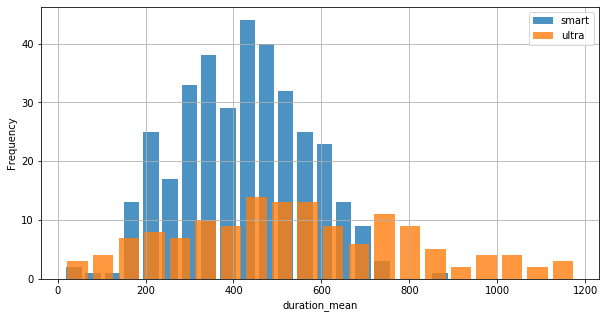

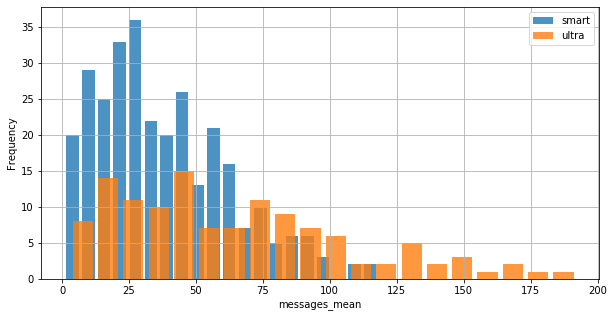

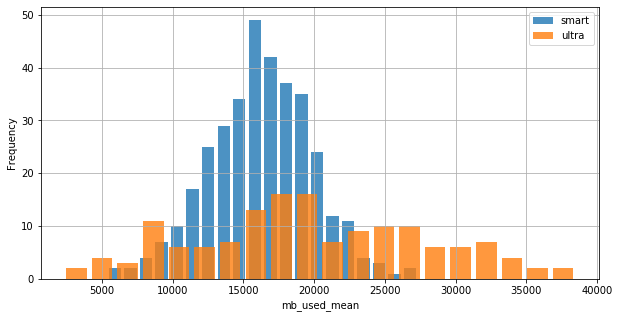

In [523]:
column_name_counter = 0
for table in tables_for_analysis:
    for key in tariffs_dict:
        table.reindex(tariffs_dict[key].values)['user_mean'].plot.hist(
        bins=20, grid=True, figsize=(10,5), rwidth=0.8, alpha=0.8, label=key, legend=True,
        )
    plt.xlabel(column_names_mean[column_name_counter])
    plt.show()
    column_name_counter += 1

По построенным графикам видно, что, для пользователей тарифа **ultra**, в отличие от **smart**, характерно более равномерное распределение по всему диапазону значений для каждого из изучаемых параметров.\
Для гистограмм **duration_mean** и **mb_used_mean** характерно нормальное распределение, в то время как для таблицы **messages_mean** имеем явную скошенность вправо.

Чтобы ответить на вопрос _"Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?"_ для каждой таблицы посчитаем среднее, дисперсию и стандартное отклонение.'\
Значения запишем в новую таблицу.

#### Добавляем средние значения

In [524]:
users_behavior_data = pd.DataFrame(index=tariffs_dict.keys())
column_name_counter = 0
for table in tables_for_analysis:
    col=[]
    for key in tariffs_dict:
        col.append(table.reindex(tariffs_dict[key].values)['user_mean'].mean())
    
    users_behavior_data[column_names_mean[column_name_counter]] = col 
    column_name_counter += 1    
users_behavior_data

,duration_mean,messages_mean,mb_used_mean
smart,420.848019,37.575606,16237.003015
ultra,546.998401,64.555802,19762.435602


#### Добавляем дисперсию

In [525]:
column_names_var = [ 'duration_var', 'messages_var', 'mb_used_var']
column_name_counter = 0
for table in tables_for_analysis:
    col=[]
    for key in tariffs_dict:
        col.append(np.var(table.reindex(tariffs_dict[key].values)['user_mean']))
    
    users_behavior_data[column_names_var[column_name_counter]] = col 
    column_name_counter += 1    
users_behavior_data

,duration_mean,messages_mean,mb_used_mean,duration_var,messages_var,mb_used_var
smart,420.848019,37.575606,16237.003015,20519.312699,615.464763,1.311852e+07
ultra,546.998401,64.555802,19762.435602,71369.465259,1867.561788,6.641472e+07


#### Добавляем стандартное отклонение

In [526]:
column_names_std = [ 'duration_std', 'messages_std', 'mb_used_std']
column_name_counter = 0
for table in tables_for_analysis:
    col=[]
    for key in tariffs_dict:
        col.append(np.std(table.reindex(tariffs_dict[key].values)['user_mean']))
    
    users_behavior_data[column_names_std[column_name_counter]] = col 
    column_name_counter += 1 
users_behavior_data

,duration_mean,messages_mean,mb_used_mean,duration_var,messages_var,mb_used_var,duration_std,messages_std,mb_used_std
smart,420.848019,37.575606,16237.003015,20519.312699,615.464763,1.311852e+07,143.245638,24.808562,3621.950207
ultra,546.998401,64.555802,19762.435602,71369.465259,1867.561788,6.641472e+07,267.150642,43.215296,8149.522910


#### Переименуем таблицу:

In [527]:
users_behavior_data.columns = [
    'Средняя длительность мин.',
    'Среднее кол-во сообщ.',
    'Средний трафик Мб',
    'Дисперсия длительности',
    'Дисперсия кол-ва сообщ.',
    'Дисперсия трафика',
    'Ст. отклонение длительности',
    'Ст. отклонение кол-ва сообщений',
    'Ст. отклонение трафика'
]
users_behavior_data

,Средняя длительность мин.,Среднее кол-во сообщ.,Средний трафик Мб,Дисперсия длительности,Дисперсия кол-ва сообщ.,Дисперсия трафика,Ст. отклонение длительности,Ст. отклонение кол-ва сообщений,Ст. отклонение трафика
smart,420.848019,37.575606,16237.003015,20519.312699,615.464763,1.311852e+07,143.245638,24.808562,3621.950207
ultra,546.998401,64.555802,19762.435602,71369.465259,1867.561788,6.641472e+07,267.150642,43.215296,8149.522910


### Вывод:
На данном этапе были обработаны данные, описывающие поведение пользователей. Это было необходимо, для ответа на вопрос **_"Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?"_**\ 

В результате получены следующие значения:

**В среднем за месяц** для пользователей тарифа **"Смарт"**:
- Минут разговора: **421 мин.**
- Сообщений: **37**
- Объем интернет-трафика: **16 Гб**
    
**В среднем за месяц** для пользователей тарифа **"Ультра"**:
- Минут разговора: **547 мин.**
- Сообщений: **65**
- Объем интернет-трафика: **20 Гб**

Более подробная информация представлена в таблице ниже:

In [528]:
users_behavior_data

,Средняя длительность мин.,Среднее кол-во сообщ.,Средний трафик Мб,Дисперсия длительности,Дисперсия кол-ва сообщ.,Дисперсия трафика,Ст. отклонение длительности,Ст. отклонение кол-ва сообщений,Ст. отклонение трафика
smart,420.848019,37.575606,16237.003015,20519.312699,615.464763,1.311852e+07,143.245638,24.808562,3621.950207
ultra,546.998401,64.555802,19762.435602,71369.465259,1867.561788,6.641472e+07,267.150642,43.215296,8149.522910


Изучая гистограммы, а также данные таблицы `users_behavior_data`, можно выявить следующие закономерности:
- Пользователи тарифа **smart**, как правило, не превышают лимиты по длительности разговора и количеству отправленных сообщений, но **используют** в среднем **16 Гб** интернет трафика, **что превышает лимит тарифа на 1 Гб.**
- Пользователи тарифа **ultra** никогда не превышают лимиты по длительности разговора и количеству сообщений, и, как правило, **используют 20 Гб интернет-трафика в месяц, что 10 Гб меньше лимита, установленного тарифом.**
- **Стандартное отклонение** для пользователей тарифа **ultra**, в среднем, **в 2 раза выше по всем параметрам**, в сравнении с показателями для тарифа **smart**, что свидетельствует о большем разбросе в объеме использованния услуг.

На этом анализ данных можно завершить, дан ответ на поставленный вопрос.

---

## Проверка гипотез

На этом этапе необходимо проверить две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Для проверки воспользуемся данными созданной ранее таблицы `users_income_data`, содержащей информацию о помесячной выручке с каждого пользователя.

### Гипотеза 1
#### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Сформулируем нулевую гипотезу, так, чтобы она имела смысл "ничто не различается между двумя группами данных".
В данном случае **нулевая гипотеза** будет звучать так: 
- **Средняя выручка пользователей тарифов «Смарт» и «Ультра» _не различается_**

На основе этого сформулируем **альтернативную гипотезу**: 
- **Средняя выручка пользователей тарифов «Смарт» и «Ультра» _различается_**

При этом альтернативная гипотеза является **двусторонней**, так как средняя выручка для тарифа **Смарт** может оказаться как больше, так и меньше средней выручки для тарифа **Ультра**.

Для проверки гипотез необходимо добавить столбец **user_mean** в таблицу `users_income_data`, на основе которого и будем сравнивать две группы пользователей.

In [529]:
users_income_data['user_mean'] = users_income_data[users_income_data > 0].apply('mean', axis=1)
users_income_data.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,user_mean
1000.0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950.000000
1001.0,0,0,0,0,0,0,0,0,0,0,0,550,550.000000
1002.0,0,0,0,0,0,0,987.695,1524.02,814.062,550,1184.77,1092.38,1025.488281


Проверяем гипотезы с помощью t-теста, указав параметр **equal_var=False**, т.к. есть основания полагать, что дисперсии выборок значительно отличаются.
Уровень статистической значимости **alpha** зададим стандартным значением в **5%**.

In [577]:
alpha = 0.05

results = st.ttest_ind(
users_income_data.reindex(tariffs_dict['smart'])['user_mean'].dropna().tolist(),
users_income_data.reindex(tariffs_dict['ultra'])['user_mean'].dropna().tolist(),  
equal_var=False
)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не удалось отвергнуть нулевую гипотезу")

p-value: 2.2864631884437073e-25
Отвергаем нулевую гипотезу


Мы опровергли нулевую гипотезу, значит средняя выручка пользователей тарифов «Смарт» и «Ультра» **различается**.

Стоит уточнить как именно. Для этого узнаем среднюю выручку по тарифам, взятую для всех пользователей.

In [584]:
for key in tariffs_dict:
    print(key, 'mean income:',
    users_income_data.reindex(tariffs_dict[key])['user_mean'].mean()
    )

smart mean income: 1467.0489253846722
ultra mean income: 2130.6407810668065


Выходит, средняя выручка пользователей тарифа **ultra** больше на **700р.**\
Это довольно серьезная разница, которая говорит о том, что пользователи тарифа **ultra** приносят в среднем на 30% больше денег, чем пользователи тарифа **smart**.

Также интересен тот факт, что тариф **smart**, при ежемесячной плате в **550р.**, в среднем приносит **1467р.**, на пользователя.

### Гипотеза 2
#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
По аналогии с гипотезой 1, сформулируем **нулевую гипотезу** так:
- **Средняя выручка пользователей из Москвы _не отличается_ от выручки пользователей из других регионов.**

Отталкиваясь от нулевой гипотеза, сформулируем **альтернативную гипотезу**: 
- **Средняя выручка пользователей из Москвы _отличается_ от выручки пользователей из других регионов.**

Также как и в предыдущем случае, альтернативная гипотеза является **двусторонней**, так как средняя выручка пользователей из **Москвы** может оказаться как больше, так и меньше средней выручки пользователей из **других регионов**.

Воспользовавшись таблицей `users_data`, создадим словарь, в котором будет два ключа: **moscow** и **other**, содержащий id пользователей из соответствующих регионов.\
Этот словарь будет нужен для разделения пользователей на две группы в зависимости от места проживания.

In [564]:
cities_dict = {
'moscow':users_data[users_data.city == 'Москва'].index,
'other':users_data[users_data.city != 'Москва'].index
}

Воспользуемся t-тестом для проверки гипотез. По аналогии с предыдущей гипотезой, укажем параметры **equal_var** = **False**, **alpha** = **0.05**.

In [576]:
alpha = 0.05

results=st.ttest_ind(
users_income_data.reindex(cities_dict['moscow'])['user_mean'].dropna().tolist(),
users_income_data.reindex(cities_dict['other'])['user_mean'].dropna().tolist(),
equal_var=False
)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 0.5142558027053894
Не удалось отвергнуть нулевую гипотезу


Выходит, по имеющейся выборке **нельзя утверждать, что средняя выручка пользователей из Москвы, отличается от выручки пользователей из других регионов**.

Взглянем на средние значения по всем пользователям:

In [585]:
for key in cities_dict:
    print(key, 'mean income:',
    users_income_data.reindex(cities_dict[key])['user_mean'].mean()
    )

moscow mean income: 1621.7750465279778
other mean income: 1680.4638105190484


Как ни странно, средняя выручка для пользователей из Москвы практически не отличается от средней выручки по другим регионам.

### Вывод:
На данном этапе были выдвинуты и проверены две нулевые гипотезы:
- **Средняя выручка пользователей тарифов «Смарт» и «Ультра» _не различается_**
- **Средняя выручка пользователей из Москвы _не отличается_ от выручки пользователей из других регионов.**

Проверка первой гипотезы показала, что средняя **выручка тарифа «Ультра» больше**, чем в тарифе «Смарт», причём существенно (порядка **30%**).

Проверка второй гипотезы показала, что **нет существенных различий** в средней выручке для пользователей **Москвы** в сравнении с **другими регионами**.

---

## Общий вывод:

Целью этого проекта было выявление наиболее выгодного тарифа на основе анализа данных небольшой выборки пользователей.

Работа состоит из следующих этапов:
- Ознакомление с данными
- Предобработка
- Подготовка данных для анализа
- Анализ
- Проверка гипотез

<br>

**На первом этапе** были загружены все необходимые для работы таблицы, проведен первичный анализ присутствующих проблем в данных. В результате были выявлены и исправлены проблемы:
- Столбцы с датой имели тип данных **object**
- В таблице `calls_data` записи о звонках с нулевой длительностью
- В таблице `internet_data` записи о сессиях, в которых не было потрачено ни одного мегабайта.
- В таблице `users_data` пропущенные значения в столбце **churn_date**.
- В таблице `tariffs_data` опечатка в названии столбца **mb_per_month_included**

<br>

**На втором этапе** были посчитаны необходимые для дальнейшего анализа значения.\
Они записаны в следующие таблицы:
- `calls_number_by_month` - количество сделанных звонков по месяцам
- `duration_by_month` - количество израсходованных минут разговора по месяцам
- `messages_by_month` - количество отправленных сообщений по месяцам
- `mb_used_by_month` - объем израсходованного интернет-трафика по месяцам
- `users_income_data` - помесячная выручка

При этом длительность звонков и количество использованных мегабайт предварительно были округлены в большую сторону для корректного их учета. В созданных таблицах, а также в таблице `users_data`, столбец user_id служит индексом.

<br>

**На третьем этапе** был дан ответ на вопрос **_"Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?"_**\
Получены следующие значения:

**В среднем за месяц** для пользователей тарифа **"Смарт"**:
- Минут разговора: **421 мин.**
- Сообщений: **37**
- Объем интернет-трафика: **16 Гб**
    
**В среднем за месяц** для пользователей тарифа **"Ультра"**:
- Минут разговора: **547 мин.**
- Сообщений: **65**
- Объем интернет-трафика: **20 Гб**

<br>

**На четвертом этапе** были выдвинуты и проверены следующие гипотезы:
- **Средняя выручка пользователей тарифов «Смарт» и «Ультра» _не различается_**
- **Средняя выручка пользователей из Москвы _не отличается_ от выручки пользователей из других регионов.**

Проверка первой гипотезы показала, что средняя **выручка тарифа «Ультра» больше**, чем в тарифе «Смарт», причём существенно (порядка **30%**).

Проверка второй гипотезы показала, что **нет существенных различий** в средней выручке для пользователей **Москвы** в сравнении с **другими регионами**.

### По итогу работы можно сделать следующий вывод о выгодности тарифов:

## Тариф «Ультра» приносит больше денег.